In [19]:
%pip install pandas matplotlib scikit-learn seaborn ipympl scipy
import numpy as np
import math
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Define constants used for power modelling

In [3]:
# Solar cell power production in mW
solar_cell_chosen_power_production_mW = 500  

# MPPT charger efficiency in %
mppt_charger_efficiency_percent = 95  

# Energy storage
# Calculate energy storage in joules from voltage and capacity

liion_battery = False
hycap_vpc = True
if hycap_vpc:
    nominal_voltage_V = 3.8
    min_voltage_V = 2.5
    capacitance_F = 250  
    energy_storage_J = (0.5 * nominal_voltage_V**2 * capacitance_F) - (0.5 * min_voltage_V**2 * capacitance_F)  # Formula for energy storage in joules (0.5 * C * V^2)
elif liion_battery:
    nominal_voltage_V = 3.7 
    mAh_capacity = 1000 
    # Calculate energy storage in joules: E = V * Q
    energy_storage_J = nominal_voltage_V * mAh_capacity * 3.6  # 3.600 converts mAh to Coulombs

# Boost converter efficiency
boost_converter_efficiency_percent = 90  

# IoT core quiescent power draw
iot_core_chosen_quiescent_power_draw_uW = 500  

# Air quality sensor sample energy consumption
air_quality_sensor_sample_energy_consumption_C = 3.96  # Coulomb data collected with measurements
air_quality_sensor_sample_energy_consumption_J = air_quality_sensor_sample_energy_consumption_C * 5  # All sensors are 5V

air_quality_sensors = ['SPS30', 'SEN55', 'NextPM', 'HPMA115', 'SDS011']
air_quality_sensors_sample_energy_consumption = [1.54*5, 3.96*5, 4.24*5, 3.47*5, 5.19*5]
air_quality_sensors_combined = np.vstack((air_quality_sensors, air_quality_sensors_sample_energy_consumption))
print(air_quality_sensors_combined)

desired_samples_per_hour = 30

[['SPS30' 'SEN55' 'NextPM' 'HPMA115' 'SDS011']
 ['7.7' '19.8' '21.200000000000003' '17.35' '25.950000000000003']]


# Calculate charge time based off solar cell energy generation

Energy storage: 1023.75 Joules
Solar cell power production: 0.5 mW, Charge time: 598.68 hours
Solar cell power production: 1.0 mW, Charge time: 299.34 hours
Solar cell power production: 1.5 mW, Charge time: 199.56 hours
Solar cell power production: 2.0 mW, Charge time: 149.67 hours
Solar cell power production: 2.5 mW, Charge time: 119.74 hours
Solar cell power production: 3.0 mW, Charge time: 99.78 hours
Solar cell power production: 3.5 mW, Charge time: 85.53 hours
Solar cell power production: 4.0 mW, Charge time: 74.84 hours
Solar cell power production: 4.5 mW, Charge time: 66.52 hours
Solar cell power production: 5.0 mW, Charge time: 59.87 hours
Solar cell power production: 5.5 mW, Charge time: 54.43 hours
Solar cell power production: 6.0 mW, Charge time: 49.89 hours
Solar cell power production: 6.5 mW, Charge time: 46.05 hours
Solar cell power production: 7.0 mW, Charge time: 42.76 hours
Solar cell power production: 7.5 mW, Charge time: 39.91 hours
Solar cell power production: 8.0 m

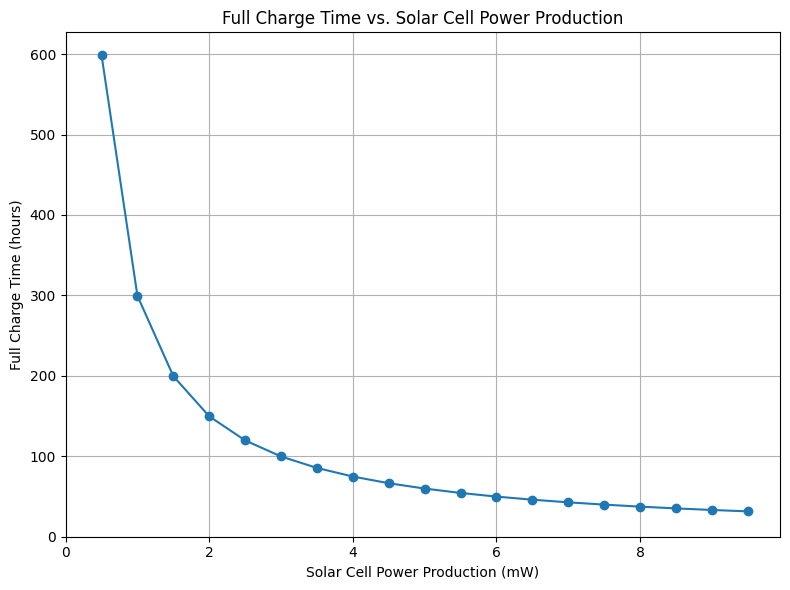

In [4]:
# Varying solar cell power production in mW
solar_cell_power_production_range_mW = np.arange(0.5, 10, 0.5)  # Adjust range as needed
print(f'Energy storage: {energy_storage_J} Joules')
# Calculate full charge time for each solar cell power production
full_charge_times = []
for solar_cell_power_production_mW in solar_cell_power_production_range_mW:
    # Effective solar cell power production after MPPT charger efficiency
    effective_solar_cell_power_production_mW = solar_cell_power_production_mW * (mppt_charger_efficiency_percent / 100)
    
    # Calculate charge time
    charge_time_hours = (energy_storage_J * 1000) / (effective_solar_cell_power_production_mW * 3600)
    full_charge_times.append(charge_time_hours)
    print(f'Solar cell power production: {solar_cell_power_production_mW} mW, Charge time: {charge_time_hours:.2f} hours')

# Plotting
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(solar_cell_power_production_range_mW, full_charge_times, marker='o')  # Added marker
ax.set_xlabel('Solar Cell Power Production (mW)')
ax.set_ylabel('Full Charge Time (hours)')
ax.set_title('Full Charge Time vs. Solar Cell Power Production')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(True)
plt.tight_layout()
plt.show()

# Calculate idle run time based off IoT core quiescent current

IoT core quiescent power draw: 50 uW, Run time: 5118.75 hours
IoT core quiescent power draw: 100 uW, Run time: 2559.38 hours
IoT core quiescent power draw: 150 uW, Run time: 1706.25 hours
IoT core quiescent power draw: 200 uW, Run time: 1279.69 hours
IoT core quiescent power draw: 250 uW, Run time: 1023.75 hours
IoT core quiescent power draw: 300 uW, Run time: 853.12 hours
IoT core quiescent power draw: 350 uW, Run time: 731.25 hours
IoT core quiescent power draw: 400 uW, Run time: 639.84 hours
IoT core quiescent power draw: 450 uW, Run time: 568.75 hours
IoT core quiescent power draw: 500 uW, Run time: 511.88 hours
IoT core quiescent power draw: 550 uW, Run time: 465.34 hours
IoT core quiescent power draw: 600 uW, Run time: 426.56 hours
IoT core quiescent power draw: 650 uW, Run time: 393.75 hours
IoT core quiescent power draw: 700 uW, Run time: 365.63 hours
IoT core quiescent power draw: 750 uW, Run time: 341.25 hours
IoT core quiescent power draw: 800 uW, Run time: 319.92 hours
IoT 

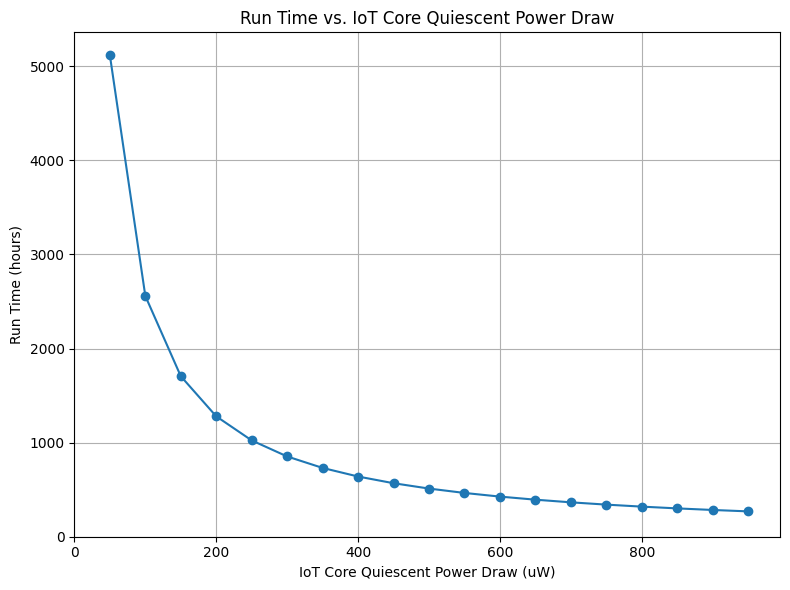

In [5]:
# Function to calculate run time
def calculate_run_time(iot_core_quiescent_power_draw_uW):
    # Adjust IoT core quiescent power draw for boost converter inefficiency
    adjusted_quiescent_power_draw_uW = iot_core_quiescent_power_draw_uW / (boost_converter_efficiency_percent / 100)
    
    # Calculate run time
    run_time_hours = energy_storage_J / (adjusted_quiescent_power_draw_uW * 0.000001) / 3600
    
    return run_time_hours

# Varying IoT core quiescent power draw
iot_core_quiescent_power_draw_values = np.arange(50, 1000, 50) 
# Calculate run time for each IoT core quiescent power draw value
run_times_hours = []
for iot_core_quiescent_power_draw in iot_core_quiescent_power_draw_values:
    run_time = calculate_run_time(iot_core_quiescent_power_draw)
    run_times_hours.append(run_time)
    print(f'IoT core quiescent power draw: {iot_core_quiescent_power_draw} uW, Run time: {run_time:.2f} hours')

# Plotting
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(iot_core_quiescent_power_draw_values, run_times_hours, marker='o')  # Added marker
ax.set_xlabel('IoT Core Quiescent Power Draw (uW)')
ax.set_ylabel('Run Time (hours)')
ax.set_title('Run Time vs. IoT Core Quiescent Power Draw')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(True)
plt.tight_layout()
plt.show()


# Calculate equivalent power consumption from duty cycle and consumption for one measurement

In [6]:
# Array of frequency (measurements per hour)
frequency_measurements_per_hour = [1, 2, 5, 10, 20, 30, 60]  # Example frequencies: 1, 2, 4, 6, 8, 12 measurements per hour

# Calculate average power consumption for each frequency
average_power_consumption_array = []
for frequency in frequency_measurements_per_hour:
    hourly_energy_consumption = air_quality_sensor_sample_energy_consumption_J * frequency
    
    hourly_average_power_consumption = hourly_energy_consumption / 3.6
    
    average_power_consumption_array.append((frequency, hourly_average_power_consumption))

# Display array
print("Frequency (measurements per hour) and Average Power Consumption:")
print(average_power_consumption_array)

Frequency (measurements per hour) and Average Power Consumption:
[(1, 5.5), (2, 11.0), (5, 27.5), (10, 55.0), (20, 110.0), (30, 165.0), (60, 330.0)]


In [7]:
air_quality_sensors_combined[1,1]
beans = air_quality_sensors_combined[1,1]
beans

'19.8'

Solar cell power production: 0.5 mW, Max frequency: 0.20 Measurements per hour
Solar cell power production: 25.5 mW, Max frequency: 10.19 Measurements per hour
Solar cell power production: 50.5 mW, Max frequency: 20.19 Measurements per hour
Solar cell power production: 75.5 mW, Max frequency: 30.18 Measurements per hour
Solar cell power production: 100.5 mW, Max frequency: 40.17 Measurements per hour
Solar cell power production: 125.5 mW, Max frequency: 50.17 Measurements per hour
Solar cell power production: 0.5 mW, Max frequency: 0.08 Measurements per hour
Solar cell power production: 25.5 mW, Max frequency: 3.96 Measurements per hour
Solar cell power production: 50.5 mW, Max frequency: 7.85 Measurements per hour
Solar cell power production: 75.5 mW, Max frequency: 11.74 Measurements per hour
Solar cell power production: 100.5 mW, Max frequency: 15.62 Measurements per hour
Solar cell power production: 125.5 mW, Max frequency: 19.51 Measurements per hour
Solar cell power production: 0

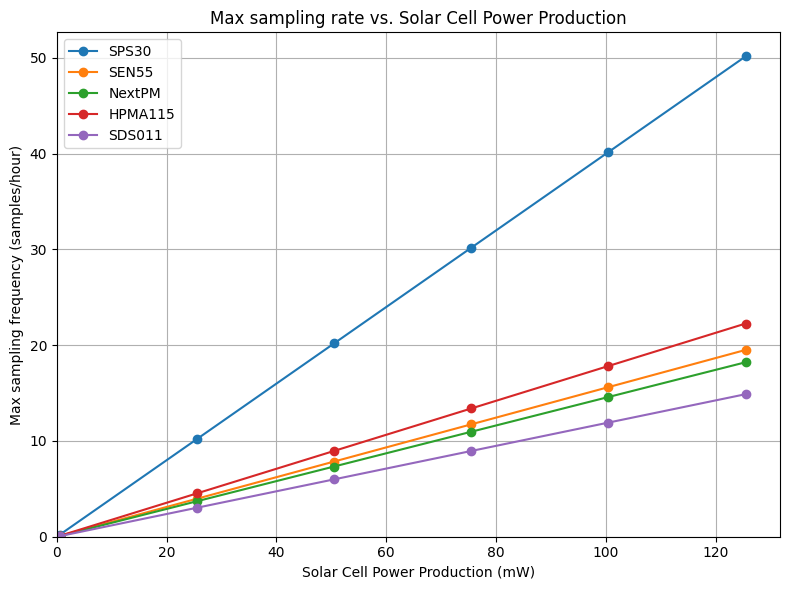

In [8]:
# Varying solar cell power production in mW
solar_cell_power_production_range_mW = np.arange(0.5, 150, 25)  # Adjust range as needed
# Calculate full charge time for each solar cell power production

# Plotting
fig, ax = plt.subplots(figsize=(8,6))

for i in range(air_quality_sensors_combined.shape[1]):
    name = air_quality_sensors_combined[0,i]
    max_frequency = []
    for solar_cell_power_production_mW in solar_cell_power_production_range_mW:
        # Effective solar cell power production after MPPT charger efficiency
        effective_solar_cell_power_production_mW = solar_cell_power_production_mW * (mppt_charger_efficiency_percent / 100)
        effective_sensor_power_mw = effective_solar_cell_power_production_mW * (boost_converter_efficiency_percent/100)
        available_hourly_energy = effective_sensor_power_mw * 3.6
        frequency = available_hourly_energy/float(air_quality_sensors_combined[1,i])
        max_frequency.append(frequency)
        print(f'Solar cell power production: {solar_cell_power_production_mW} mW, Max frequency: {frequency:.2f} Measurements per hour')
    ax.plot(solar_cell_power_production_range_mW, max_frequency, marker='o', label=name)



ax.set_xlabel('Solar Cell Power Production (mW)')
ax.set_ylabel('Max sampling frequency (samples/hour)')
ax.set_title('Max sampling rate vs. Solar Cell Power Production')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(True)
# add a legend to the plot
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('ghi.csv')

# Assuming your CSV has columns 'time' and 'GHI' for time and global horizontal irradiance respectively
# If your CSV has different column names, replace 'time' and 'GHI' with your actual column names
time_column = 'Time'
ghi_column = 'GHI'

# Convert the 'time' column to datetime format
df[time_column] = pd.to_datetime(df[time_column])

# Optionally, set the 'time' column as the index
df.set_index(time_column, inplace=True)
df[ghi_column] = df[ghi_column].fillna(0)

max_ghi = df[ghi_column].max()
df['GHI_normalized'] = df[ghi_column] / max_ghi

# Display the first few rows of the DataFrame to verify the normalization
df


,GHI,GHI_normalized
Time,,
2024-04-03 00:00:00,0.0,0.0
2024-04-03 00:01:00,0.0,0.0
2024-04-03 00:02:00,0.0,0.0
2024-04-03 00:03:00,0.0,0.0
2024-04-03 00:04:00,0.0,0.0
...,...,...
2024-04-03 23:55:00,0.0,0.0
2024-04-03 23:56:00,0.0,0.0
2024-04-03 23:57:00,0.0,0.0


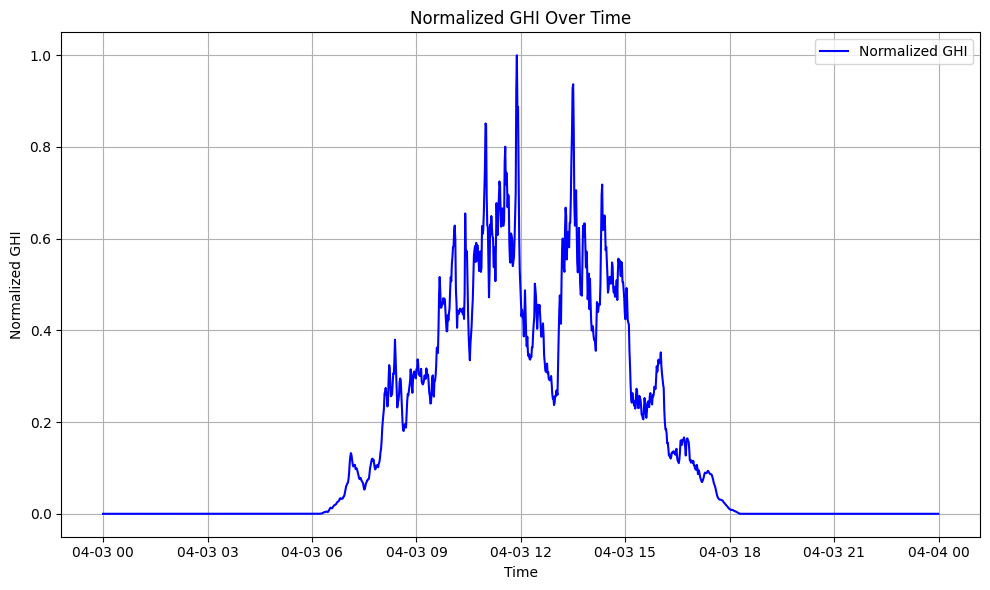

In [10]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['GHI_normalized'], color='blue', label='Normalized GHI')
plt.title('Normalized GHI Over Time')
plt.xlabel('Time')
plt.ylabel('Normalized GHI')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

In [11]:
df['GHI_normalized'][390:400]

Time
2024-04-03 06:30:00    0.009328
2024-04-03 06:31:00    0.011741
2024-04-03 06:32:00    0.013179
2024-04-03 06:33:00    0.013040
2024-04-03 06:34:00    0.011833
2024-04-03 06:35:00    0.012762
2024-04-03 06:36:00    0.014525
2024-04-03 06:37:00    0.016288
2024-04-03 06:38:00    0.018145
2024-04-03 06:39:00    0.019073
Name: GHI_normalized, dtype: float64

In [12]:

cumulative_energy = np.zeros(1)
for ghi in df['GHI_normalized']:
    print(ghi)
    cumulative_energy = np.append(cumulative_energy, (ghi*60*solar_cell_chosen_power_production_mW* (mppt_charger_efficiency_percent / 100)/1000 + cumulative_energy[-1]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [13]:
cumulative_energy

array([   0.        ,    0.        ,    0.        , ..., 6556.85817503,
       6556.85817503, 6556.85817503])

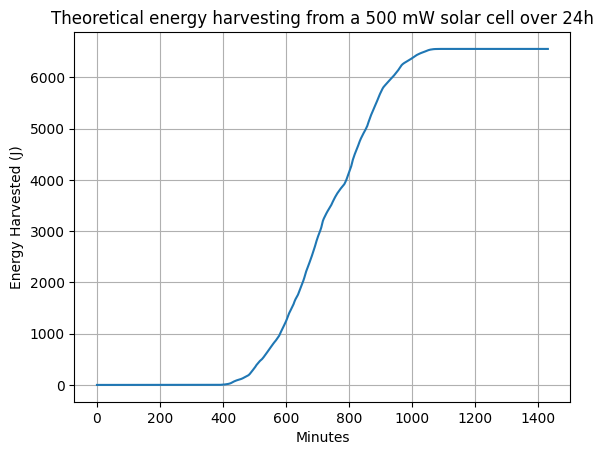

In [14]:
# Plot the array
plt.plot(cumulative_energy)
plt.xlabel('Minutes')
plt.ylabel('Energy Harvested (J)')
plt.title(f'Theoretical energy harvesting from a {solar_cell_chosen_power_production_mW} mW solar cell over 24h')
plt.grid(True)
plt.show()

In [15]:


for i in range(air_quality_sensors_combined.shape[1]):
    name = air_quality_sensors_combined[0,i]
    hourly_samples_posisble = float(cumulative_energy[-1]) / (float(air_quality_sensors_combined[1,i])*24 * (100/boost_converter_efficiency_percent))
    print(f'Sensor: {name}, Max frequency: {hourly_samples_posisble:.2f} Measurements per hour')
    

Sensor: SPS30, Max frequency: 31.93 Measurements per hour
Sensor: SEN55, Max frequency: 12.42 Measurements per hour
Sensor: NextPM, Max frequency: 11.60 Measurements per hour
Sensor: HPMA115, Max frequency: 14.17 Measurements per hour
Sensor: SDS011, Max frequency: 9.48 Measurements per hour


In [16]:
for i in range(air_quality_sensors_combined.shape[1]):
    name = air_quality_sensors_combined[0,i]
    total_samples_possible = energy_storage_J / (float(air_quality_sensors_combined[1,i]) * (100/boost_converter_efficiency_percent))
    print(f'Sensor: {name}, Max samples: {total_samples_possible:.2f} Measurements ')

Sensor: SPS30, Max samples: 119.66 Measurements 
Sensor: SEN55, Max samples: 46.53 Measurements 
Sensor: NextPM, Max samples: 43.46 Measurements 
Sensor: HPMA115, Max samples: 53.11 Measurements 
Sensor: SDS011, Max samples: 35.51 Measurements 


In [27]:
# find number of minutes of total darkness
count_zero = (df['GHI_normalized'] == 0).sum()
print("Minutes of tial darkness:", count_zero)

hours_of_darkness = math.ceil(count_zero/60)

num_of_samples_in_darkness = hours_of_darkness*desired_samples_per_hour

for i in range(air_quality_sensors_combined.shape[1]):
    name = air_quality_sensors_combined[0,i]
    energy_requirements = num_of_samples_in_darkness * (float(air_quality_sensors_combined[1,i]) * (100/boost_converter_efficiency_percent))
    energy_requirements = energy_requirements + (hours_of_darkness * (iot_core_chosen_quiescent_power_draw_uW * 0.000001) * 3600 / (boost_converter_efficiency_percent / 100))
    battery_size = energy_requirements/(3.7*3.6)
    print(f'Sensor: {name}, Energy store requirements: {energy_requirements:.2f} J , {battery_size:.2f} mAh')



Minutes of tial darkness: 716
Sensor: SPS30, Energy store requirements: 3104.00 J , 233.03 mAh
Sensor: SEN55, Energy store requirements: 7944.00 J , 596.40 mAh
Sensor: NextPM, Energy store requirements: 8504.00 J , 638.44 mAh
Sensor: HPMA115, Energy store requirements: 6964.00 J , 522.82 mAh
Sensor: SDS011, Energy store requirements: 10404.00 J , 781.08 mAh


In [29]:
cumulative_light = np.zeros(1)
for ghi in df['GHI_normalized']:
    cumulative_light = np.append(cumulative_light, (ghi*60* (mppt_charger_efficiency_percent / 100)/1000 + cumulative_light[-1]))
cumulative_light[-1]
num_of_samples = desired_samples_per_hour * 24

for i in range(air_quality_sensors_combined.shape[1]):
    name = air_quality_sensors_combined[0,i]
    energy_requirements = num_of_samples * (float(air_quality_sensors_combined[1,i]) * (100/boost_converter_efficiency_percent))
    energy_requirements = energy_requirements + (24 * (iot_core_chosen_quiescent_power_draw_uW * 0.000001) * 3600 / (boost_converter_efficiency_percent / 100))
    needed_solar_dell_production_mw = energy_requirements/cumulative_light[-1]
    print(f'Sensor: {name}, Solar cell power production: {needed_solar_dell_production_mw:.2f} mW')


Sensor: SPS30, Energy store requirements: 473.40 mW
Sensor: SEN55, Energy store requirements: 1211.56 mW
Sensor: NextPM, Energy store requirements: 1296.96 mW
Sensor: HPMA115, Energy store requirements: 1062.09 mW
Sensor: SDS011, Energy store requirements: 1586.74 mW
